# Generate LINCS Figures

**Gregory Way, 2020**

The figures generated in this notebook represent figure 4 and a supplementary figures

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source(file.path("scripts", "visualize_utils.R"))
source(file.path("repurposing_cellhealth_shiny", "util.R"))
source(file.path("repurposing_cellhealth_shiny", "dose_utils.R"))

In [2]:
# Define a function to test enrichment of a particular moa in a model
get_enrichment <- function(df, moa, model, hypothesis = "greater") {
    midway_point <- quantile(df %>% dplyr::pull(!!model), 0.5)
    midway_point <- as.numeric(paste(midway_point))
    
    cp_greater_df <- df %>%
        dplyr::filter((df %>% dplyr::pull(!!model)) > midway_point)
    cp_less_df <- df %>%
        dplyr::filter((df %>% dplyr::pull(!!model)) <= midway_point)
    
    num_moa_high <- dim(cp_greater_df %>% dplyr::filter(moa == !!moa))[1]
    num_moa_low <- dim(cp_less_df %>% dplyr::filter(moa == !!moa))[1]

    num_notmoa_high <- dim(cp_greater_df %>% dplyr::filter(moa != !!moa))[1]
    num_notmoa_low <- dim(cp_less_df %>% dplyr::filter(moa != !!moa))[1]

    contingency_mat <- matrix(
        c(
            c(num_moa_high, num_moa_low),
            c(num_notmoa_high, num_notmoa_low)
        ),
        nrow = 2
    )
    
    result <- fisher.test(contingency_mat, alternative = hypothesis)
    return(result)
}

In [3]:
consensus = "modz"

In [4]:
# Load data
data <- load_data(path="repurposing_cellhealth_shiny/")
cp_embedding_df <- data[["moa"]]

cp_embedding_df <- cp_embedding_df %>%
    dplyr::mutate(Metadata_Treatment = "Compound")

cp_embedding_df$Metadata_Treatment[cp_embedding_df$Metadata_broad_core_id == "DMSO"] = "DMSO"

print(dim(cp_embedding_df))
head(cp_embedding_df, 3)

[1] 10368    88


Metadata_Plate_Map_Name,Metadata_broad_core_id,Metadata_broad_sample,Metadata_dose_recode,Metadata_mmoles_per_liter,Metadata_pert_well,umap_x,umap_y,broad_id,pert_iname,⋯,cc_g2_high_h2ax,cc_late_mitosis_n_spots_h2ax_mean,cc_cc_high_h2ax,vb_percent_dead_only,cc_s_high_h2ax,cc_cc_n_spots_h2ax_per_nucleus_area_mean,cc_s_n_spots_h2ax_per_nucleus_area_mean,cc_g1_plus_g2_count,vb_live_cell_width_length,Metadata_Treatment
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C-7161-01-LM6-001,BRD-A25234499,BRD-A25234499-001-18-3,6,10.0000,B13,-1.580029,-0.9219316,BRD-A25234499,aminoglutethimide,⋯,0.2751957,0.2319843,0.03473731,0.2267767,0.237375,0.10548474,0.1536775,-0.5309856,0.14445485,Compound
C-7161-01-LM6-001,BRD-A25234499,BRD-A25234499-001-18-3,5,3.3333,B14,-1.904766,-2.4360995,BRD-A25234499,aminoglutethimide,⋯,0.5169502,0.2421589,0.01257728,0.6328903,0.399858,0.02291539,0.2027969,-0.1597692,-0.29454513,Compound
C-7161-01-LM6-001,BRD-A25234499,BRD-A25234499-001-18-3,4,1.1111,B15,-1.899164,-2.5914881,BRD-A25234499,aminoglutethimide,⋯,0.4012496,0.2682545,0.08088620,0.2074322,0.337209,0.18061697,0.2859738,-0.2541855,-0.04831094,Compound


In [5]:
# Load Dose and Rank information
dose_df <- data[["dose"]]
rank_df <- data[["rank"]]

model_dict_df <- rank_df %>%
    dplyr::select(target, readable_name)
model_dict_df$target <- paste(model_dict_df$target)
model_dict_df$readable_name <- paste(model_dict_df$readable_name)

# Reshape the moa dataframe for different variable plotting
melt_id_vars <- c(
  "Metadata_Plate_Map_Name",
  "Metadata_pert_well",
  "Metadata_broad_core_id",
  "Metadata_broad_sample",
  "Metadata_dose_recode",
  "Metadata_mmoles_per_liter",
  "umap_x",
  "umap_y",
  "broad_id",
  "pert_iname",
  "InChIKey14",
  "moa",
  "target",
  "clinical_phase",
  "alternative_moa",
  "alternative_target",
  "broad_date"
)

moa_long_df <- reshape2::melt(
  cp_embedding_df,
  id.vars = melt_id_vars,
  value.name = "model_score",
  variable.name = "model"
)

moa_long_df$model <- paste(moa_long_df$model)
moa_long_df <- moa_long_df %>%
  dplyr::left_join(model_dict_df, by = c("model" = "target"))

moa_long_df$model_score <- as.numeric(paste(moa_long_df$model_score))

head(moa_long_df)

,Metadata_Plate_Map_Name,Metadata_pert_well,Metadata_broad_core_id,Metadata_broad_sample,Metadata_dose_recode,Metadata_mmoles_per_liter,umap_x,umap_y,broad_id,pert_iname,InChIKey14,moa,target,clinical_phase,alternative_moa,alternative_target,broad_date,model,model_score,readable_name
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,C-7161-01-LM6-001,B13,BRD-A25234499,BRD-A25234499-001-18-3,6,10.000000,-1.580029,-0.9219316,BRD-A25234499,aminoglutethimide,ROBVIMPUHSLWNV,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,Launched,NA,NA,broad_id_20170327,cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,0.1218401,Late M - # of gH2AX Spots per Area of Nucleus
2,C-7161-01-LM6-001,B14,BRD-A25234499,BRD-A25234499-001-18-3,5,3.333300,-1.904766,-2.4360995,BRD-A25234499,aminoglutethimide,ROBVIMPUHSLWNV,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,Launched,NA,NA,broad_id_20170327,cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,0.1355173,Late M - # of gH2AX Spots per Area of Nucleus
3,C-7161-01-LM6-001,B15,BRD-A25234499,BRD-A25234499-001-18-3,4,1.111100,-1.899164,-2.5914881,BRD-A25234499,aminoglutethimide,ROBVIMPUHSLWNV,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,Launched,NA,NA,broad_id_20170327,cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,0.1814137,Late M - # of gH2AX Spots per Area of Nucleus
4,C-7161-01-LM6-001,B16,BRD-A25234499,BRD-A25234499-001-18-3,3,0.370370,-1.708769,-0.8860601,BRD-A25234499,aminoglutethimide,ROBVIMPUHSLWNV,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,Launched,NA,NA,broad_id_20170327,cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,0.1684181,Late M - # of gH2AX Spots per Area of Nucleus
5,C-7161-01-LM6-001,B17,BRD-A25234499,BRD-A25234499-001-18-3,2,0.123460,-1.857128,-2.7086122,BRD-A25234499,aminoglutethimide,ROBVIMPUHSLWNV,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,Launched,NA,NA,broad_id_20170327,cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,0.1958430,Late M - # of gH2AX Spots per Area of Nucleus
6,C-7161-01-LM6-001,B18,BRD-A25234499,BRD-A25234499-001-18-3,1,0.041152,-1.860059,-2.6781860,BRD-A25234499,aminoglutethimide,ROBVIMPUHSLWNV,glucocorticoid receptor antagonist,CYP11A1|CYP19A1,Launched,NA,NA,broad_id_20170327,cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,0.2555105,Late M - # of gH2AX Spots per Area of Nucleus


In [6]:
# Load True Cell Counts
batch <- "2016_04_01_a549_48hr_batch1"
lincs_commit <- "e6852b49992b4fa2f0d36cc07011856ebee6326a"
raw_url <- paste0("https://raw.githubusercontent.com/broadinstitute/lincs-cell-painting/", lincs_commit)
barcode_platemap_file <- paste0(raw_url, "/metadata/platemaps/", batch, "/barcode_platemap.csv")
barcode_platemap_df <- readr::read_csv(barcode_platemap_file, col_types = readr::cols())

plates <- unique(barcode_platemap_df$Assay_Plate_Barcode)
platemaps <- unique(barcode_platemap_df$Plate_Map_Name)
print(length(plates))
print(length(platemaps))

[1] 140
[1] 28


In [7]:
# Load platemaps
platemap_data <- list()
for (platemap in platemaps) {
    platemap_file <- paste0(
        raw_url, "/metadata/platemaps/", batch, "/", "platemap", "/", platemap, ".txt"
    )
    
    platemap_df <- readr::read_tsv(platemap_file, col_types = readr::cols())
    platemap_df$broad_sample <- tidyr::replace_na(platemap_df$broad_sample, "DMSO")
    platemap_df$mg_per_ml <- tidyr::replace_na(platemap_df$mg_per_ml, 0)
    platemap_df$mmoles_per_liter <- tidyr::replace_na(platemap_df$mmoles_per_liter, 0)
    
    platemap_data[[platemap]] <- platemap_df
}

In [8]:
# Load Cell Count Files
cell_count_data = list()
for (plate in plates) {
    platemap_name <- barcode_platemap_df %>%
        dplyr::filter(Assay_Plate_Barcode == !!plate) %>% dplyr::pull(Plate_Map_Name)
    
    platemap_df <- platemap_data[[platemap_name]]

    cell_count_file <- paste0(
        raw_url, "/profiles/cell_count/", batch, "/", plate, "/", plate, "_cell_count.csv"
    )
    
    cell_count_df <- tryCatch({
        readr::read_csv(cell_count_file, col_types = readr::cols()) %>%
            dplyr::left_join(platemap_df, by = c("Image_Metadata_Well" = "well_position"))
        }, error = function(w) {
            return("not found")
    })
    
    if (cell_count_df == "not found") {
        next
    } else {
        cell_count_data[[plate]] <- cell_count_df
    }
}

# Combine and process cell count files
all_count_df <- do.call(rbind, cell_count_data) %>%
    dplyr::group_by(plate_map_name, Image_Metadata_Well, broad_sample, mmoles_per_liter) %>%
    dplyr::mutate(mean_cell_count = mean(cell_count)) %>%
    dplyr::select(plate_map_name, Image_Metadata_Well, broad_sample, mmoles_per_liter, mean_cell_count) %>%
    dplyr::distinct() %>%
    dplyr::mutate(dose_merge = round(mmoles_per_liter, 4))

cell_count_info <- all_count_df %>%
    dplyr::right_join(cp_embedding_df %>%
        dplyr::mutate(dose_merge = round(Metadata_mmoles_per_liter, 4)),
                 by = c("plate_map_name" = "Metadata_Plate_Map_Name",
                        "Image_Metadata_Well" = "Metadata_pert_well",
                        "dose_merge" = "dose_merge"))

head(cell_count_info, 3)

plate_map_name,Image_Metadata_Well,broad_sample,mmoles_per_liter,mean_cell_count,dose_merge,Metadata_broad_core_id,Metadata_broad_sample,Metadata_dose_recode,Metadata_mmoles_per_liter,⋯,cc_g2_high_h2ax,cc_late_mitosis_n_spots_h2ax_mean,cc_cc_high_h2ax,vb_percent_dead_only,cc_s_high_h2ax,cc_cc_n_spots_h2ax_per_nucleus_area_mean,cc_s_n_spots_h2ax_per_nucleus_area_mean,cc_g1_plus_g2_count,vb_live_cell_width_length,Metadata_Treatment
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C-7161-01-LM6-001,B13,BRD-A25234499-001-18-3,10.000000,2445.4,10.0000,BRD-A25234499,BRD-A25234499-001-18-3,6,10.0000,⋯,0.2751957,0.2319843,0.03473731,0.2267767,0.237375,0.10548474,0.1536775,-0.5309856,0.14445485,Compound
C-7161-01-LM6-001,B14,BRD-A25234499-001-18-3,3.333333,2365.4,3.3333,BRD-A25234499,BRD-A25234499-001-18-3,5,3.3333,⋯,0.5169502,0.2421589,0.01257728,0.6328903,0.399858,0.02291539,0.2027969,-0.1597692,-0.29454513,Compound
C-7161-01-LM6-001,B15,BRD-A25234499-001-18-3,1.111111,2353.4,1.1111,BRD-A25234499,BRD-A25234499-001-18-3,4,1.1111,⋯,0.4012496,0.2682545,0.08088620,0.2074322,0.337209,0.18061697,0.2859738,-0.2541855,-0.04831094,Compound


In [9]:
# Load Viability Validation
validation_file = file.path(
    "..", "5.validate-repurposing", "results", "depmap_viability_validation.tsv.gz"
)

validation_df <- readr::read_tsv(validation_file, col_types = readr::cols())

print(dim(validation_df))
head(validation_df, 3)

[1] 5977   89


Metadata_Plate_Map_Name,Metadata_broad_sample,Metadata_pert_well,Metadata_mmoles_per_liter,Metadata_dose_recode,cell_health_modz_target_cc_late_mitosis_n_spots_h2ax_per_nucleus_area_mean,cell_health_modz_target_cc_all_nucleus_roundness_mean,cell_health_modz_target_cc_polyploid_n_objects,cell_health_modz_target_cc_g1_n_objects,cell_health_modz_target_cc_mitosis_n_objects,⋯,disease.area,dose,indication,moa,name,phase,screen_id,smiles,target,dose_recode
<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
C-7161-01-LM6-001,BRD-A25234499-001-18-3,B13,10.0000,6,0.1218401,0.28787578,0.3321284,0.03166791,0.2935131,⋯,"endocrinology, oncology",10.0,"Cushing's syndrome, breast cancer",glucocorticoid receptor antagonist,aminoglutethimide,Launched,HTS002,"CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1=O)c1ccc(N)cc1","CYP11A1, CYP19A1",6
C-7161-01-LM6-001,BRD-A25234499-001-18-3,B14,3.3333,5,0.1355173,-0.01698349,0.1758055,0.04546745,0.2712013,⋯,"endocrinology, oncology",2.5,"Cushing's syndrome, breast cancer",glucocorticoid receptor antagonist,aminoglutethimide,Launched,HTS,"CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1=O)c1ccc(N)cc1","CYP11A1, CYP19A1",5
C-7161-01-LM6-001,BRD-A25234499-001-18-3,B14,3.3333,5,0.1355173,-0.01698349,0.1758055,0.04546745,0.2712013,⋯,"endocrinology, oncology",2.5,"Cushing's syndrome, breast cancer",glucocorticoid receptor antagonist,aminoglutethimide,Launched,HTS002,"CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1=O)c1ccc(N)cc1","CYP11A1, CYP19A1",5


In [10]:
# Subset controls and compounds
cp_embedding_df$Metadata_Controls <- "Compounds"
cp_embedding_df$Metadata_Controls[cp_embedding_df$Metadata_broad_sample == "DMSO"] <- "DMSO"
cp_embedding_df$Metadata_Controls[cp_embedding_df$pert_iname == "bortezomib"] <- "bortezomib"
cp_embedding_df$Metadata_Controls[cp_embedding_df$pert_iname == "MG-132"] <- "MG-132"

table(cp_embedding_df$Metadata_Controls)

control_df <- cp_embedding_df %>% dplyr::filter(Metadata_Controls != "Compounds")
control_df$Metadata_Controls <- factor(
    control_df$Metadata_Controls, levels = c("DMSO", "bortezomib", "MG-132")
)
compound_df <- cp_embedding_df %>%
    dplyr::filter(Metadata_Controls == "Compounds")


bortezomib  Compounds       DMSO     MG-132 
       330       9066        648        324 

## Figure 4

In [11]:
figure_theme <- theme(
    axis.text = element_text(size = 7),
    axis.title = element_text(size = 9),
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 7)
)

In [12]:
# Panel A - Dose Diferences
panel_a_gg = ggplot(
    validation_df, aes(y = dose, x = Metadata_mmoles_per_liter)
    ) +
    geom_abline(slope = 1, intercept = 0, alpha = 0.6, lwd = 0.4, linetype = "dashed", color = "red") +
    geom_point(size = 0.3, alpha = 1) +
    theme_bw() +
    ylab("PRISM Dose\n(micromoles per liter)") +
    xlab("Drug Repurposing Dose\n(micromoles per liter)") +
    coord_fixed()

In [13]:
# Generate text for panel B
# Calculate correlation between orthogonal tests
spearman_result <- cor.test(
    validation_df$cell_health_viability,
    validation_df$depmap_viability,
    method = "spearman")

pval <- spearman_result$p.value
if (pval < 0.001) {
    print(paste0("Calculated p value: ", pval))
    # For presentation purposes:
    pval <- "p < 10e-3"
} else {
    pval <- paste0("p = ", pval)
}
stat <- round(as.numeric(paste(spearman_result$estimate)), 3)

result_text = paste0("Spearman = ", stat, "\n", pval)

result_text

[1] "Calculated p value: 8.1854556917826e-167"


[1] "Spearman = 0.345\np < 10e-3"

In [14]:
# Panel B - Dose Correlation
panel_b_gg = ggplot(validation_df,
                    aes(x = cell_health_viability, y = depmap_viability)) +
    geom_point(size = 0.5, alpha = 0.3) +
    theme_bw() +
    geom_smooth(method = "lm", formula = y~x) +
    annotate("text", label = result_text, x = -2, y = -8.5, size = 2.5) +
    xlab("Cell Health Model Predictions\n(Number of Live Cells)") +
    ylab("PRISM Assay\n(A549 Phycoerythrin Intensity)") +
    coord_fixed() +
    theme()

In [15]:
# Subset data for panel c
focus_moa <- "PLK inhibitor"

moa_df <- compound_df %>% dplyr::filter(moa == !!focus_moa)
print(dim(moa_df))

# What are the existing PLK inhibitors
table(moa_df$pert_iname)

[1] 30 89



    BI-2536   GSK461364     HMN-214 NMS-1286937  volasertib 
          6           6           6           6           6 

In [16]:
# Define enrichment of select MOAs in select models
moa <- "proteasome inhibitor"
model <- "vb_ros_mean"

get_enrichment(cp_embedding_df, moa, model)


	Fisher's Exact Test for Count Data

data:  contingency_mat
p-value < 2.2e-16
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 36.15699      Inf
sample estimates:
odds ratio 
   76.6861 


In [17]:
# Define enrichment of select MOAs in select models
moa <- "PLK inhibitor"
model <- "cc_g1_n_objects"

get_enrichment(cp_embedding_df, moa, model, hypothesis = "less")


	Fisher's Exact Test for Count Data

data:  contingency_mat
p-value = 3.915e-08
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
 0.000000 0.177995
sample estimates:
odds ratio 
0.03514183 


In [18]:
# Panel C
panel_c_gg <- ggplot(compound_df,
       aes(
           x = cc_g1_n_objects,
           y = vb_ros_mean,
           color = Metadata_dose_recode
       )) +
    geom_point(
        aes(shape = Metadata_Controls),
        data = compound_df %>% dplyr::filter(moa != "PLK inhibitor"),
        size = 0.5,
        alpha = 0.6
    ) +
    geom_point(
        data = control_df,
        aes(shape = Metadata_Controls),
        fill = "red",
        color = "black",
        size = 1,
        alpha = 0.4,
    ) +
    geom_point(
        data = moa_df,
        aes(fill = Metadata_dose_recode,
            shape = moa),
        color = "black",
        size = 2,
        alpha = 0.7
    ) +
    theme_bw() +
    ylab("Predicted ROS") +
    xlab("Predicted G1 Cell Count") +
    scale_shape_manual(
        name = "Point Labels",
        values = c("DMSO" = 21,
                   "bortezomib" = 23,
                   "MG-132" = 25,
                   "PLK inhibitor" = 24,
                   "Compounds" = 16),
        labels = c("DMSO" = "DMSO",
                   "bortezomib" = "Bortezomib",
                   "MG-132" = "MG-132",
                   "PLK inhibitor" = "PLK inhibitor",
                   "Compounds" = "Other")
      ) +
    scale_color_continuous(name = "Dose Rank") +
    scale_fill_continuous(name = "Dose Rank") +
    guides(shape = guide_legend(order = 1,
                                override.aes = list(size = c(2, 1, 2, 2, 3.5))))

# Generate Figure 4C Figure Legend
dose_rank_fill_legend <- cowplot::get_legend(
    ggplot(compound_df, aes(x = cc_g1_n_objects, y = vb_ros_mean, color = Metadata_dose_recode)) +
    geom_point(data = compound_df,
               size = 0.5,
               alpha = 0.6) +
    scale_color_continuous(name = "Dose Rank") +
    figure_theme +
    theme(legend.key.size = unit(0.5, "lines"))
)

control_point_label_legend <- cowplot::get_legend(
    ggplot(compound_df,
           aes(x = cc_g1_n_objects,
               y = vb_ros_mean,
               color = Metadata_dose_recode)) +
    geom_point(data = control_df,
               aes(
                   shape = Metadata_Controls),
                   fill = "red",
                   color = "black",
                   size = 1,
                   alpha = 0.4
              ) +
    scale_shape_manual(name = "Controls",
                       values = c("DMSO" = 21,
                                  "bortezomib" = 23,
                                  "MG-132" = 25),
                       labels = c("DMSO" = "DMSO",
                                  "bortezomib" = "Bortezomib",
                                  "MG-132" = "MG-132")) +
    theme_bw() +
    figure_theme +
    theme(legend.key.size = unit(0.4, "lines"))
    )

compound_point_label_legend <- cowplot::get_legend(
    ggplot(compound_df,
           aes(x = cc_g1_n_objects,
               y = vb_ros_mean)) +
    geom_point(data = compound_df,
               aes(shape = Metadata_Controls), size = 0.5) +
    geom_point(data = moa_df,
               aes(shape = moa),
               color = "black",
               size = 2,
               alpha = 0.7) +
    scale_shape_manual(name = "Compounds",
                       values = c("PLK inhibitor" = 24,
                                  "Compounds" = 16),
                       labels = c("PLK inhibitor" = "PLK inhibitor",
                                  "Compounds" = "Other")) +
    theme_bw() +
    guides(shape = guide_legend(
        order = 1,
        override.aes = list(size = c(0.5, 2))
    ))  +
    figure_theme +
    theme(legend.key.size = unit(0.4, "lines"))
)

# Put everything together into a single figure
panel_c_with_legend <- cowplot::ggdraw(
    panel_c_gg +
    theme(legend.position = "none") +
    figure_theme +
    cowplot::draw_plot(
        control_point_label_legend, x = 0.8, y = 50
        ) +
    cowplot::draw_plot(
        compound_point_label_legend, x = 0.8, y = 37
        ) +
    cowplot::draw_plot(
        dose_rank_fill_legend, x = 0.65, y = 22
        ) 
)

In [19]:
# Panel D - Dose Response
panel_d_gg <- suppressWarnings(
    get_dose_curve(
        moa_long_df,
        dose_df,
        model = "cc_g1_n_objects",
        pert_name = "HMN-214",
        cell_health_model = "G1 Cell Count"
    )
) + ylab("Predicted\nG1 Cell Count")

In [20]:
# Prep data for plotting panel e
dna_damage_g1_density_df <- cp_embedding_df %>%
    dplyr::mutate(density_class = "Other Compound")

aurorakinase_inhibit <- grepl("Aurora", cp_embedding_df$moa)
tubulin_inhibit <- grepl("tubulin", cp_embedding_df$moa)

dna_damage_g1_density_df[aurorakinase_inhibit, "density_class"] <- "Aurora Kinase Inhibitor"
dna_damage_g1_density_df[tubulin_inhibit, "density_class"] <- "Tubulin Inhibitor"
dna_damage_g1_density_df[tubulin_inhibit, "density_class"] <- "Tubulin Inhibitor"
dna_damage_g1_density_df$density_class[dna_damage_g1_density_df$Metadata_broad_sample == "DMSO"] <- "DMSO"
dna_damage_g1_density_df$density_class[dna_damage_g1_density_df$pert_iname == "bortezomib"] <- "Proteasome Inhibitor"
dna_damage_g1_density_df$density_class[dna_damage_g1_density_df$pert_iname == "MG-132"] <- "Proteasome Inhibitor"

dna_damage_g1_density_df$density_class <- factor(
    dna_damage_g1_density_df$density_class,
    levels = c("DMSO", "Proteasome Inhibitor", "Other Compound", "Tubulin Inhibitor", "Aurora Kinase Inhibitor")
)

In [21]:
dna_damage_labels <- c(
    "DMSO" = "DMSO",
    "Proteasome Inhibitor"= "Proteasome Inhibitor",
    "Other Compound"= "Other Compound",
    "Tubulin Inhibitor"= "Tubulin Inhibitor",
    "Aurora Kinase Inhibitor"= "Aurora Kinase Inhibitor"
)

dna_damage_colors <- c(
    "DMSO" = "orange",
    "Proteasome Inhibitor"= "red",
    "Other Compound"= "yellow",
    "Tubulin Inhibitor"= "#8C72C0",
    "Aurora Kinase Inhibitor"= "#1C2D40"
)

In [22]:
# Define enrichment of tubulin and aurora kinase inhibitors
# Cannot easily use function since we're testing if two MOAs are enriched
model <- "cc_g1_n_spots_h2ax_mean"

midway_point <- quantile(dna_damage_g1_density_df %>% dplyr::pull(!!model), 0.5)
midway_point <- as.numeric(paste(midway_point))

cp_greater_df <- dna_damage_g1_density_df %>%
    dplyr::filter((dna_damage_g1_density_df %>% dplyr::pull(!!model)) > midway_point)
cp_less_df <- dna_damage_g1_density_df %>%
    dplyr::filter((dna_damage_g1_density_df %>% dplyr::pull(!!model)) <= midway_point)

# Build contingency matrix
test_moa <- c("Tubulin Inhibitor", "Aurora Kinase Inhibitor")
num_moa_high <- dim(cp_greater_df %>% dplyr::filter(density_class %in% test_moa))[1]
num_moa_low <- dim(cp_less_df %>% dplyr::filter(density_class %in% test_moa))[1]

num_notmoa_high <- dim(cp_greater_df %>% dplyr::filter(!(density_class %in% test_moa)))[1]
num_notmoa_low <- dim(cp_less_df %>% dplyr::filter(!(density_class %in% test_moa)))[1]

contingency_mat <- matrix(
    c(
        c(num_moa_high, num_moa_low),
        c(num_notmoa_high, num_notmoa_low)
    ),
    nrow = 2
)

result <- fisher.test(contingency_mat, alternative = "greater")
result


	Fisher's Exact Test for Count Data

data:  contingency_mat
p-value < 2.2e-16
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 6.750158      Inf
sample estimates:
odds ratio 
  11.25713 


In [23]:
# Panel E - DNA Damage in G1 Cell Count
panel_e_gg <- ggplot(dna_damage_g1_density_df, aes_string(x = model)) +
    geom_density(aes(fill = density_class), alpha = 0.5) +
    theme_bw() +
    figure_theme +
    theme(legend.position = c(0.75, 0.8), legend.key.size = unit(0.7, "lines")) +
    geom_vline(xintercept = midway_point, color = "red", linetype = "dashed") +
    scale_fill_manual(name = "Compound class",
                      labels = dna_damage_labels,
                      values = dna_damage_colors) +
    xlab("Predicted G1 - # of gH2AX Spots") +
    ylab("Density")

In [24]:
# Panel F - Dose Response for barasertib
panel_f_gg <- suppressWarnings(
    get_dose_curve(
        moa_long_df,
        dose_df,
        model = "cc_g1_n_spots_h2ax_mean",
        pert_name = "barasertib",
        cell_health_model = "G1 - # of gH2AX Spots"
    )
) + ylab("Predicted\nG1 - # of gH2AX Spots")

In [25]:
# Compile figure panels by row and column
panel_a_b <- cowplot::plot_grid(
    cowplot::ggdraw(),
    panel_a_gg + figure_theme + theme(plot.margin = unit(c(1, 0.5, 0.5, 0.5), "cm")),
    cowplot::ggdraw(),
    panel_b_gg + figure_theme + theme(plot.margin = unit(c(1, -0.5, 0.5, 0.5), "cm")),
    labels = c("", "a", "", "b"),
    align = "hv",
    ncol = 4,
    axis = "l",
    rel_widths = c(0.01, 1, 0.01, 1.1),
    hjust = c(0, -8, 0, -8)
)

In [26]:
panel_c_d <- cowplot::plot_grid(
    panel_c_with_legend,
    panel_d_gg + theme(axis.text.x = element_text(angle = 90)) + figure_theme,
    nrow = 2,
    align = "v",
    axis = "l",
    rel_heights = c(1, 0.7),
    labels = c("c", "d")
)

In [27]:
panel_e_f <- (
    cowplot::plot_grid(
        panel_e_gg + figure_theme,
        panel_f_gg + figure_theme + theme(axis.text.x = element_text(angle = 90)),
        nrow = 2,
        align = "v",
        axis = "l",
        rel_heights = c(1, 0.7),
        labels = c("e", "f")
    )
)

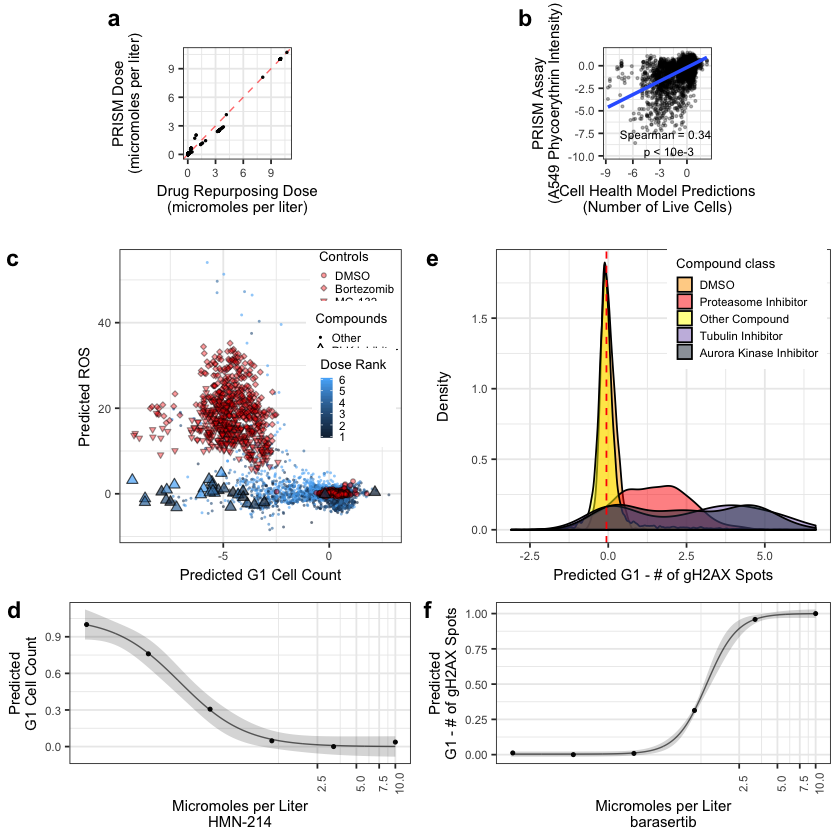

In [28]:
figure_4_gg <- cowplot::plot_grid(
    panel_a_b,
    cowplot::plot_grid(
        panel_c_d,
        panel_e_f,
        labels = c("", ""),
        axis = "l",
        align = "hv",
        rel_widths = c(1, 1),
        ncol = 2
    ),
    labels = c("", ""),
    align = "hv",
    axis = "b",
    nrow = 2,
    rel_heights = c(0.4, 1)
)

figure_file <- file.path("figures", "lincs_main_figure_4.png")

cowplot::save_plot(
    filename = figure_file,
    plot = figure_4_gg,
    dpi = 500,
    base_width = 8,
    base_height = 8
)

figure_4_gg

## Supplementary Figure

In [29]:
# Panel A
legend_title <- "Predicted\nG1 Cell\nCount"
sup_panel_a_gg <- visualize_umap(
    df = cp_embedding_df,
    target_variable = "cc_g1_n_objects",
    legend_title = legend_title,
    print_figure = FALSE
)

# Tweak the color scale to emphasize gradient
sup_panel_a_gg <- sup_panel_a_gg +
    scale_color_viridis_c(name = legend_title,
        values = scales::rescale(c(1, 0.8, 0.2)))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [30]:
# Panel B
legend_title <- "Predicted\nROS"
sup_panel_b_gg <- visualize_umap(
    df = cp_embedding_df,
    target_variable = "vb_ros_mean",
    legend_title = legend_title,
    print_figure = FALSE
)

# Tweak the color scale to emphasize gradient
sup_panel_b_gg <- sup_panel_b_gg +
    scale_color_viridis_c(name = legend_title,
        values = scales::rescale(c(1, 0.96, 0.95)))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


In [31]:
# Panel C
sup_panel_c_gg <- ggplot(cell_count_info, aes(x = umap_x, y = umap_y)) +
    xlab("UMAP X") +
    ylab("UMAP Y") +
    geom_point(aes(color = mean_cell_count),
               size = 0.65,
               pch = 16,
               alpha = 0.6) +
    geom_point(data = control_df,
              aes(shape = Metadata_Controls),
              fill = "grey",
              color = "black",
              size = 1.5,
              alpha = 0.4,
              show.legend = TRUE) +
    scale_shape_manual(
      name = "Controls",
      values = c("DMSO" = 21, "bortezomib" = 23, "MG-132" = 25),
      labels = c("DMSO" = "DMSO", "bortezomib" = "Bortezomib", "MG-132" = "MG-132")
    ) +
    theme_bw() +
    scale_color_viridis_c(name = "Mean\nGround Truth\nCell Count") +
    guides(shape = guide_legend(order = 1))

figure_file_ext <- file.path("figures", "lincs_umap_before_annotation")

for (extension in c(".png", ".pdf")) {
    figure_file <- paste0(figure_file_ext, extension)
    ggsave(figure_file, sup_panel_c_gg, dpi = 500, width = 10, height = 9)
}

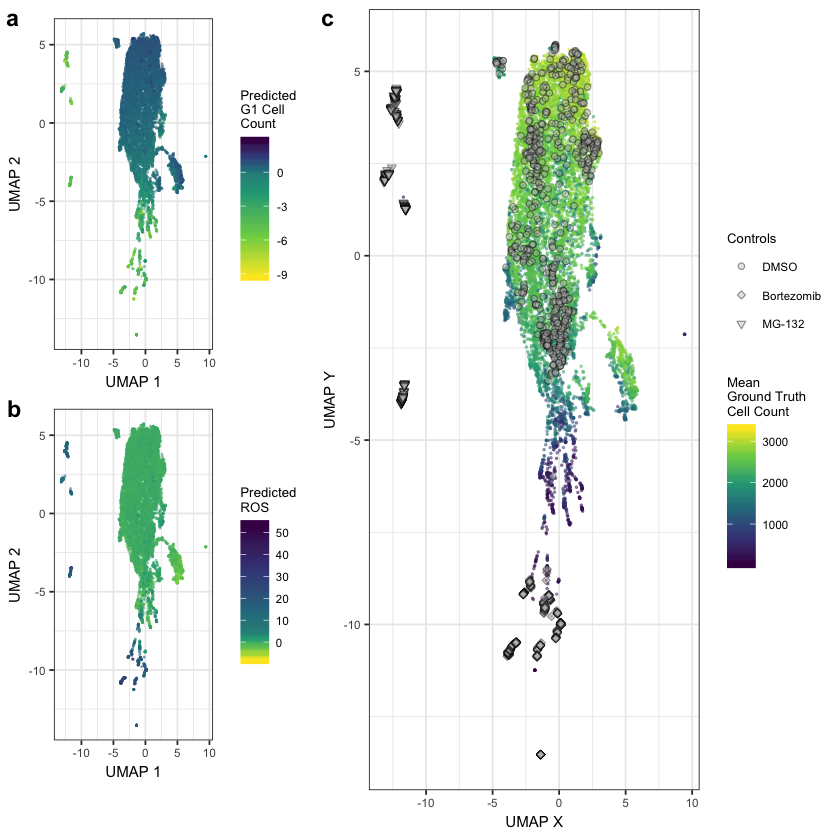

In [32]:
# Create multiplot
panel_ab <- cowplot::plot_grid(
    sup_panel_a_gg + figure_theme,
    sup_panel_b_gg + figure_theme,
    labels = c("a", "b"),
    align = "hv",
    vjust = c(1, 1),
    nrow = 2
)

sup_fig <- cowplot::plot_grid(
    panel_ab,
    sup_panel_c_gg + figure_theme,
    labels = c("", "c"),
    align = "hv",
    rel_widths = c(0.6, 1)
)

figure_file <- file.path("figures", "lincs_supplementary_figure.png")

cowplot::save_plot(
    filename = figure_file,
    plot = sup_fig,
    dpi = 500,
    base_width = 8,
    base_height = 5
)

sup_fig